In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt


In [32]:
from pathlib import Path

# `cwd`: current directory 
basepath = str(Path.cwd().parent) + '/public/data'

basepath

'/Users/feliphlvo/access-to-education/public/data'

In [33]:
access_df = pd.read_csv(f'{basepath}/access_df.csv')
access_df = gpd.GeoDataFrame(access_df, geometry = access_df["geometry"].apply(wkt.loads), crs = "EPSG:4674")

/var/folders/v6/m0s_jr6d723809xzpzrvx_340000gn/T/ipykernel_56376/398328568.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  access_df = pd.read_csv(f'{basepath}/access_df.csv')


In [34]:
access_df.columns

Index(['Unnamed: 0', 'sector_id', '3sfca_n_classes', 'e2sfca_n_classes',
       'state', 'n_households', 'n_people', 'avg_monthly_earnings',
       'n_people_15to17_white', 'n_people_15to17_black',
       'n_people_15to17_asian', 'n_people_15to17_parda',
       'n_people_15to17_indigenous', 'n_people_15', 'n_people_16',
       'n_people_17', 'n_people_15_men', 'n_people_16_men', 'n_people_17_men',
       'n_people_15_women', 'n_people_16_women', 'n_people_17_women',
       'n_people_15to17dem', 'n_people_15to17_alternative', 'state_id',
       'state_abbrev', 'city_id', 'city_name', 'district_id', 'district_name',
       'subdistrict_id', 'subdistrict_name', 'neighborhood_name',
       'neighborhood_id', 'geometry', 'microregion_id', 'microregion_name',
       'mesoregion_id', 'mesoregion_name', 'n_people_15to17', 'A', 'Q', 'H',
       'pct_black', 'pct_white', 'pct_indigenous', 'pct_pardos', 'pct_asian',
       'pct_men', 'area', 'density', 'zone_rural', 'zone_urban',
       'region_M

## Exploration of outliers

In [11]:
school_df = pd.read_csv(f'{basepath}/school_census.csv')
school_df = gpd.GeoDataFrame(school_df, geometry = school_df["geometry"].apply(wkt.loads), crs = "EPSG:4674")

In [ ]:
school_df.columns

In [9]:
# Join school_df to access_outliers to get all schools who are within a certain distance of an the centroids in access_df
access_outliers = access_df[access_df['A']>20]

# Define the distance threshold
distance_threshold = 16000  # specify your desired distance in the appropriate units

# Create a buffer around the geometries in gdfB
access_df_buffered = access_outliers.copy()
access_df_buffered['tract_geometry'] = access_df_buffered['geometry']
access_df_buffered['tract_centroid'] = access_df_buffered['geometry'].centroid
access_df_buffered['geometry'] = access_outliers.centroid.buffer(distance_threshold)

joined = gpd.sjoin(school_df, access_df_buffered, op='intersects', how='inner')

# Distance between geometry and tract_centroid
joined['distance'] = joined.apply(lambda row: row.geometry.distance(row.tract_centroid), axis=1)

# Filter the resulting DataFrame to get only the points that are within the specified distance
#within_distance = joined[joined.geometry.apply(lambda x: x.distance(access_df_buffered.geometry.iloc[joined.index[0]])) <= distance_threshold]

# Reset index if needed
#within_distance.reset_index(drop=True, inplace=True)

/Users/feliphlvo/opt/anaconda3/envs/cap_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
joined[['A','n_people_15to17', 'n_classes', 'school_name', 'city_name_left', 'distance', 'sector_id_left', 'sector_id_right']]

,A,n_people_15to17,n_classes,school_name,city_name_left,distance,sector_id_left,sector_id_right
40,38.170484,1.0,3.0,EIEEFM ROSANA CINTA LARGA,Espigão D'Oeste,9041.558252,110009805,110018915000007
152,27.096905,3.0,3.0,EIEEFM SOWAINTE,Vilhena,13241.617818,110030405,110030405000057
964,176.032343,1.0,5.0,ESCOLA ESTADUAL INDIGENA INDIO GABRIEL,Normandia,11167.415759,140040705,140040705000027
975,176.032343,1.0,3.0,ESCOLA ESTADUAL INDIGENA INDIO HERMINIO PAULINO,Normandia,9953.825829,140040705,140040705000027
974,21.000000,5.0,3.0,ESCOLA ESTADUAL INDIGENA PROFESSOR ARLINDO GAS...,Normandia,15231.714456,140040705,140040705000025
...,...,...,...,...,...,...,...,...
6265,122.967474,14.0,86.0,EE - CENTRO REGIONAL DE ENSINO MEDIO COM INTER...,Barreiras,3442.398351,290320105,292620205000015
6265,23.930330,49.0,86.0,EE - CENTRO REGIONAL DE ENSINO MEDIO COM INTER...,Barreiras,9679.295747,290320105,292620205000014
8698,20.277896,1.0,3.0,EM JOSE CABRAL VIEIRA,Monte Alegre de Minas,10590.038305,314280905,316960405000038
9534,20.277896,1.0,3.0,EM PAZ E AMOR,Tupaciguara,42.717240,316960405,316960405000038


In [11]:
# Only look at tracts in one city
m = access_df[access_df['city_name'] == 'Tupaciguara'].explore( 
    #column='A', cmap='viridis', legend=True, k=20, scheme='Quantiles'
    )
# Centroid
n = access_df[access_df['city_name'] == 'Tupaciguara'].centroid.explore(m=m, color = 'blue')
school_df[school_df['city_name']=='Tupaciguara'].explore(m=n, color="red")

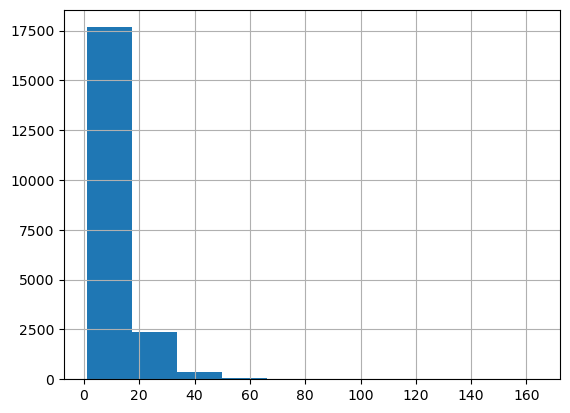

In [12]:
school_df['n_classes'].hist()
plt.show()

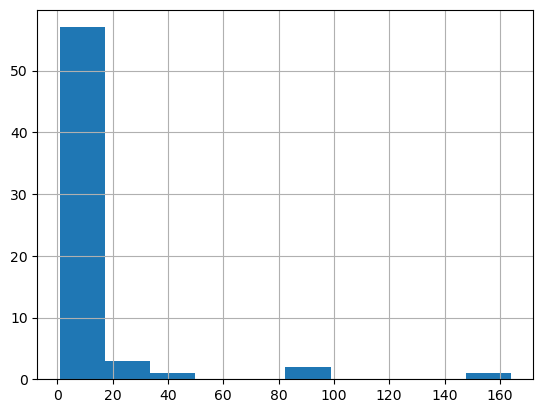

In [13]:
joined[['city_name_left', 'city_name_right', 'sector_id_left', 'school_name', 'school_id', 'n_classes']]['n_classes'].hist()
plt.show()

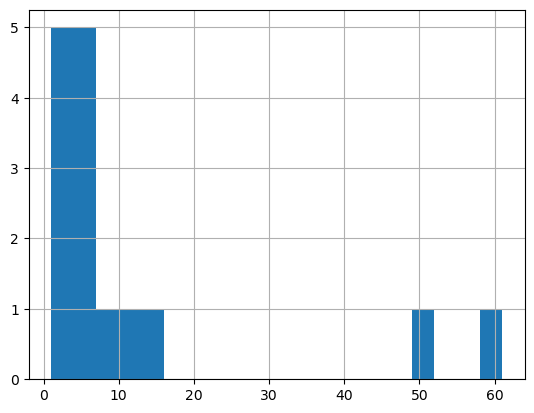

In [14]:
access_outliers['n_people_15to17'].hist(bins=20)
plt.show()

## Percentile and Normalization

In [18]:
def add_percentile(access_df, cols, groupby = 'state_id'):
    for col in cols:
        access_df[f'{col}_percentile'] = access_df.groupby(groupby)[col].rank(pct=True)
    return access_df

In [19]:
# Percentile
# Create new columns called "A_percentile", "Q_percentile", and "H_percentile" to store the percentile values
# Percentiles should be grouped and calculated by state_id

access_df = add_percentile(access_df, ['A', 'Q', 'H', 'avg_monthly_earnings', 'pct_men'], groupby = 'state_id')

In [21]:

access_df.columns

Index(['Unnamed: 0', 'sector_id', '3sfca_n_classes', 'e2sfca_n_classes',
       'state', 'n_households', 'n_people', 'avg_monthly_earnings',
       'n_people_15to17_white', 'n_people_15to17_black',
       'n_people_15to17_asian', 'n_people_15to17_parda',
       'n_people_15to17_indigenous', 'n_people_15', 'n_people_16',
       'n_people_17', 'n_people_15_men', 'n_people_16_men', 'n_people_17_men',
       'n_people_15_women', 'n_people_16_women', 'n_people_17_women',
       'n_people_15to17dem', 'n_people_15to17_alternative', 'state_id',
       'state_abbrev', 'city_id', 'city_name', 'district_id', 'district_name',
       'subdistrict_id', 'subdistrict_name', 'neighborhood_name',
       'neighborhood_id', 'geometry', 'microregion_id', 'microregion_name',
       'mesoregion_id', 'mesoregion_name', 'n_people_15to17', 'A', 'Q', 'H',
       'pct_black', 'pct_white', 'pct_indigenous', 'pct_pardos', 'pct_asian',
       'pct_men', 'area', 'density', 'zone_rural', 'zone_urban',
       'region_M

In [22]:
# Remove outliers in "A": observations with more than 3 standard deviations from the mean
# Create new columns called 'outliers' and 'outliers_std' to store the outliers and the standard deviation of the outliers

access_df['is_outlier'] = np.where(
    (access_df['A'] - access_df['A'].mean()) > 3 * access_df['A'].std(), 1, 0)

access_df['std_from_mean'] = (access_df['A'] - access_df['A'].mean()) / access_df['A'].std()


# Clip the outliers in columns "A" at 3 standard deviations from the mean

access_df['A_clipped'] = np.clip(access_df['A'], access_df['A'].mean() - 3 * access_df['A'].std(), 
access_df['A'].mean() + 3 * access_df['A'].std())


# Recalculate H
access_df['H_clipped'] = access_df['A'] * access_df['Q']


In [23]:
# Normalization
# Normalize the columns "A" and "H" to the range 0-1
# Create new columns called "A_normalized" and "H_normalized" to store the normalized values

# Normalization should be done by 'state', not the entire dataset

access_df['A_normalized'] = access_df.groupby('state_id')['A'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
access_df['H_normalized'] = access_df.groupby('state_id')['H'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

access_df['A_clipped_normalized'] = access_df.groupby('state_id')['A_clipped'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
access_df['H_clipped_normalized'] = access_df.groupby('state_id')['H_clipped'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

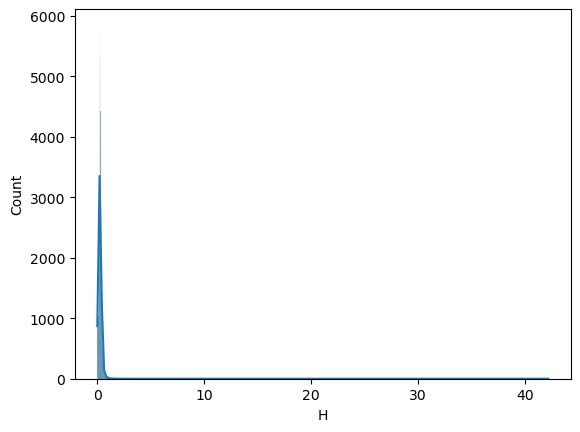

In [24]:
# Plot a histogram of the target column A to see the distribution of the data, without the outliers

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(access_df['H'], kde=True)
plt.show()

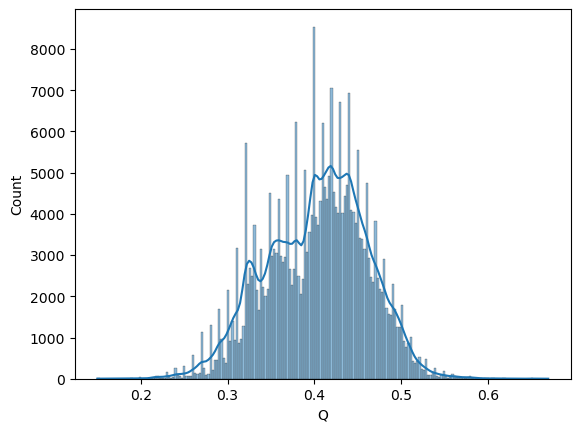

In [25]:
sns.histplot(access_df['Q'], kde=True)
plt.show()

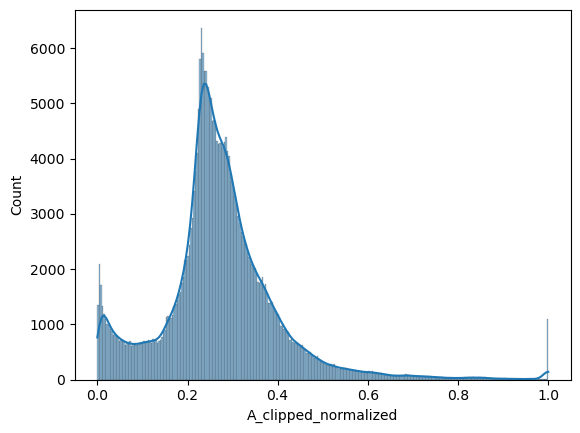

In [26]:
sns.histplot(access_df['A_clipped_normalized'], kde=True)
plt.show()

In [29]:
# Save to csv
access_df.to_csv(f'{basepath}/access_df.csv', index=False)